In [1]:
# Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score


In [2]:
!pip install imblearn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Load the dataset
df = pd.read_csv("cs-training.csv")

# Define old and new variable names
variables_old = [
    "SeriousDlqin2yrs",
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "DebtRatio",
    "MonthlyIncome",
    "NumberOfOpenCreditLinesAndLoans",
    "NumberOfTimes90DaysLate",
    "NumberRealEstateLoansOrLines",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfDependents"
]

variables_new = [
    "Defaulted",
    "Revolving Credit Utilization",             # renamed from "Revolving Utilization Of Unsecured Lines"
    "age",
    "30–59 Days PDC",                           # renamed from "Number Of Time 30-59 Days Past Due Not Worse"
    "Debt Ratio",
    "Monthly Income",
    "Open Credit Lines Count",                  # renamed from "Number Of Open Credit Lines And Loans"
    "90+ Days Late Count",                      # renamed from "Number Of Times 90 Days Late"
    "# Real Estate Loans Or Lines",
    "60–89 Days PDC",                           # renamed from "Number Of Time 60-89 Days Past Due Not Worse"
    "Number Of Dependents"
]

# Rename columns in the dataframe for shorter names, useful for the plots
df.rename(columns=dict(zip(variables_old, variables_new)), inplace=True)


In [4]:
# Investigate how the data looks
print(df.shape)

df.head()

(150000, 12)


,Unnamed: 0,Defaulted,Revolving Credit Utilization,age,30–59 Days PDC,Debt Ratio,Monthly Income,Open Credit Lines Count,90+ Days Late Count,# Real Estate Loans Or Lines,60–89 Days PDC,Number Of Dependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
# Define unrealistic value conditions based on variable semantics
cond_age = df["age"] <= 10                              # Too young for independent credit behavior
cond_util = df["Revolving Credit Utilization"] > 1000   # Usage over 1000× credit limit is institutionally implausible
cond_30_59 = df["30–59 Days PDC"] == 98                 # 98 is a placeholder for missing, not an actual count
cond_60_89 = df["60–89 Days PDC"] == 98                 # 98 is a placeholder for missing, not an actual count
cond_90_plus = df["90+ Days Late Count"] == 98          # 98 is a placeholder for missing, not an actual count

# Combine all conditions
combined_condition = cond_age | cond_util | cond_30_59 | cond_60_89 | cond_90_plus

# Extract the rows that meet any unrealistic condition
df_unrealistic = df[combined_condition]

# Print explanation for each flagged row
for idx, row in df_unrealistic.iterrows():
    reasons = []
    if row["age"] <= 10:
        reasons.append(f"age = {row['age']} → unrealistic for independent credit usage.")
    if row["Revolving Credit Utilization"] > 1000:
        reasons.append(f"Revolving Credit Utilization = {row['Revolving Credit Utilization']:.2f} → implausibly high usage ratio.")
    if row["30–59 Days PDC"] == 98:
        reasons.append("30–59 Days PDC = 98 → placeholder for missing value.")
    if row["60–89 Days PDC"] == 98:
        reasons.append("60–89 Days PDC = 98 → placeholder for missing value.")
    if row["90+ Days Late Count"] == 98:
        reasons.append("90+ Days Late Count = 98 → placeholder for missing value.")
    
    print(f"Row {idx} flagged for: " + "; ".join(reasons))

# Print summary
print(f"\nTotal rows flagged: {len(df_unrealistic)}")


Row 293 flagged for: Revolving Credit Utilization = 2340.00 → implausibly high usage ratio.
Row 697 flagged for: Revolving Credit Utilization = 2066.00 → implausibly high usage ratio.
Row 1733 flagged for: 30–59 Days PDC = 98 → placeholder for missing value.; 60–89 Days PDC = 98 → placeholder for missing value.; 90+ Days Late Count = 98 → placeholder for missing value.
Row 1991 flagged for: Revolving Credit Utilization = 1143.00 → implausibly high usage ratio.
Row 2286 flagged for: 30–59 Days PDC = 98 → placeholder for missing value.; 60–89 Days PDC = 98 → placeholder for missing value.; 90+ Days Late Count = 98 → placeholder for missing value.
Row 2331 flagged for: Revolving Credit Utilization = 6324.00 → implausibly high usage ratio.
Row 3884 flagged for: 30–59 Days PDC = 98 → placeholder for missing value.; 60–89 Days PDC = 98 → placeholder for missing value.; 90+ Days Late Count = 98 → placeholder for missing value.
Row 4278 flagged for: Revolving Credit Utilization = 1982.00 → imp

In [6]:
# Define unrealistic value conditions again
cond_age = df["age"] <= 10
cond_util = df["Revolving Credit Utilization"] > 1000
cond_30_59 = df["30–59 Days PDC"] == 98
cond_60_89 = df["60–89 Days PDC"] == 98
cond_90_plus = df["90+ Days Late Count"] == 98

# Combine all conditions
combined_condition = cond_age | cond_util | cond_30_59 | cond_60_89 | cond_90_plus

# Drop rows with unrealistic values and overwrite df
df = df[~combined_condition].reset_index(drop=True)
df = df[variables_new]

# Confirm removal
print(f"Cleaned dataset shape: {df.shape}")
print(f'{len(df_unrealistic)} observations are dropped due to unrealisitic variable values as indicated by the prints from the cell above')


Cleaned dataset shape: (149563, 11)
437 observations are dropped due to unrealisitic variable values as indicated by the prints from the cell above


In [7]:
# Compute missing value summary
missing_summary = df.isnull().sum().to_frame(name="MissingCount")
missing_summary["MissingPercentage"] = (missing_summary["MissingCount"] / len(df)) * 100

# Display only variables with missing values
missing_summary = missing_summary[missing_summary["MissingCount"] > 0]
print(missing_summary)


                      MissingCount  MissingPercentage
Monthly Income               29565          19.767590
Number Of Dependents          3882           2.595562


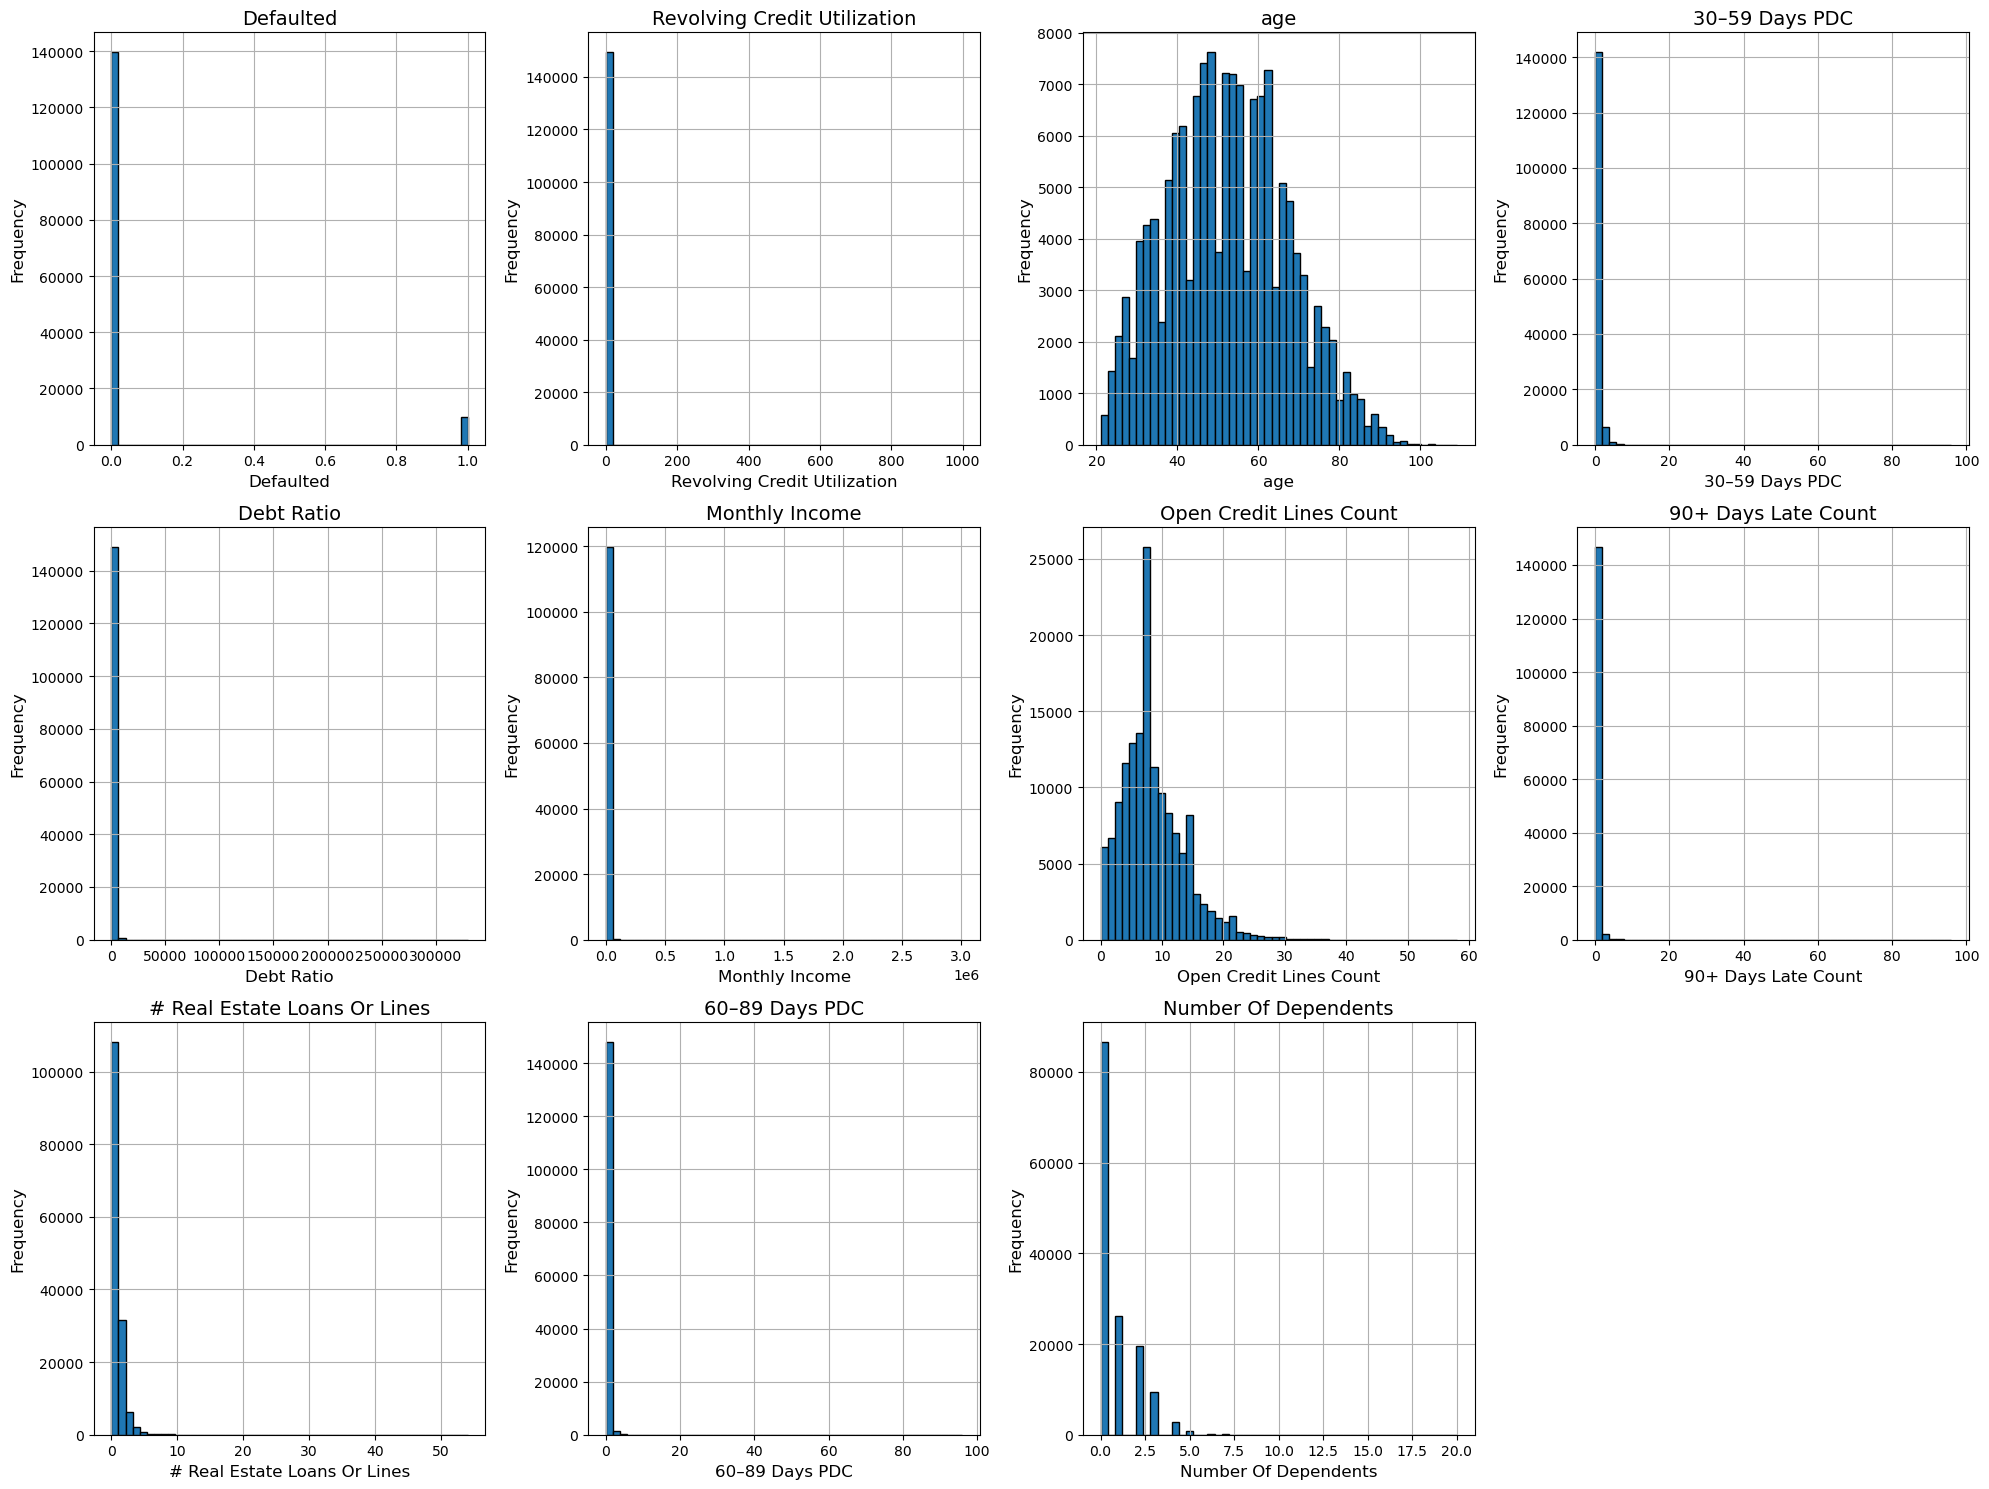

In [8]:
# Set up a 3x4 subplot grid (leaving one blank as we have 11 observed variables)
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# Plot histograms for each selected variable
for i, col in enumerate(variables_new):
    ax = axes[i]
    df[col].dropna().hist(ax=ax, bins=50, edgecolor='black')
    ax.set_title(f'{col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

# Hide the unused subplot (last one in 3x4 grid)
for j in range(len(variables_new), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


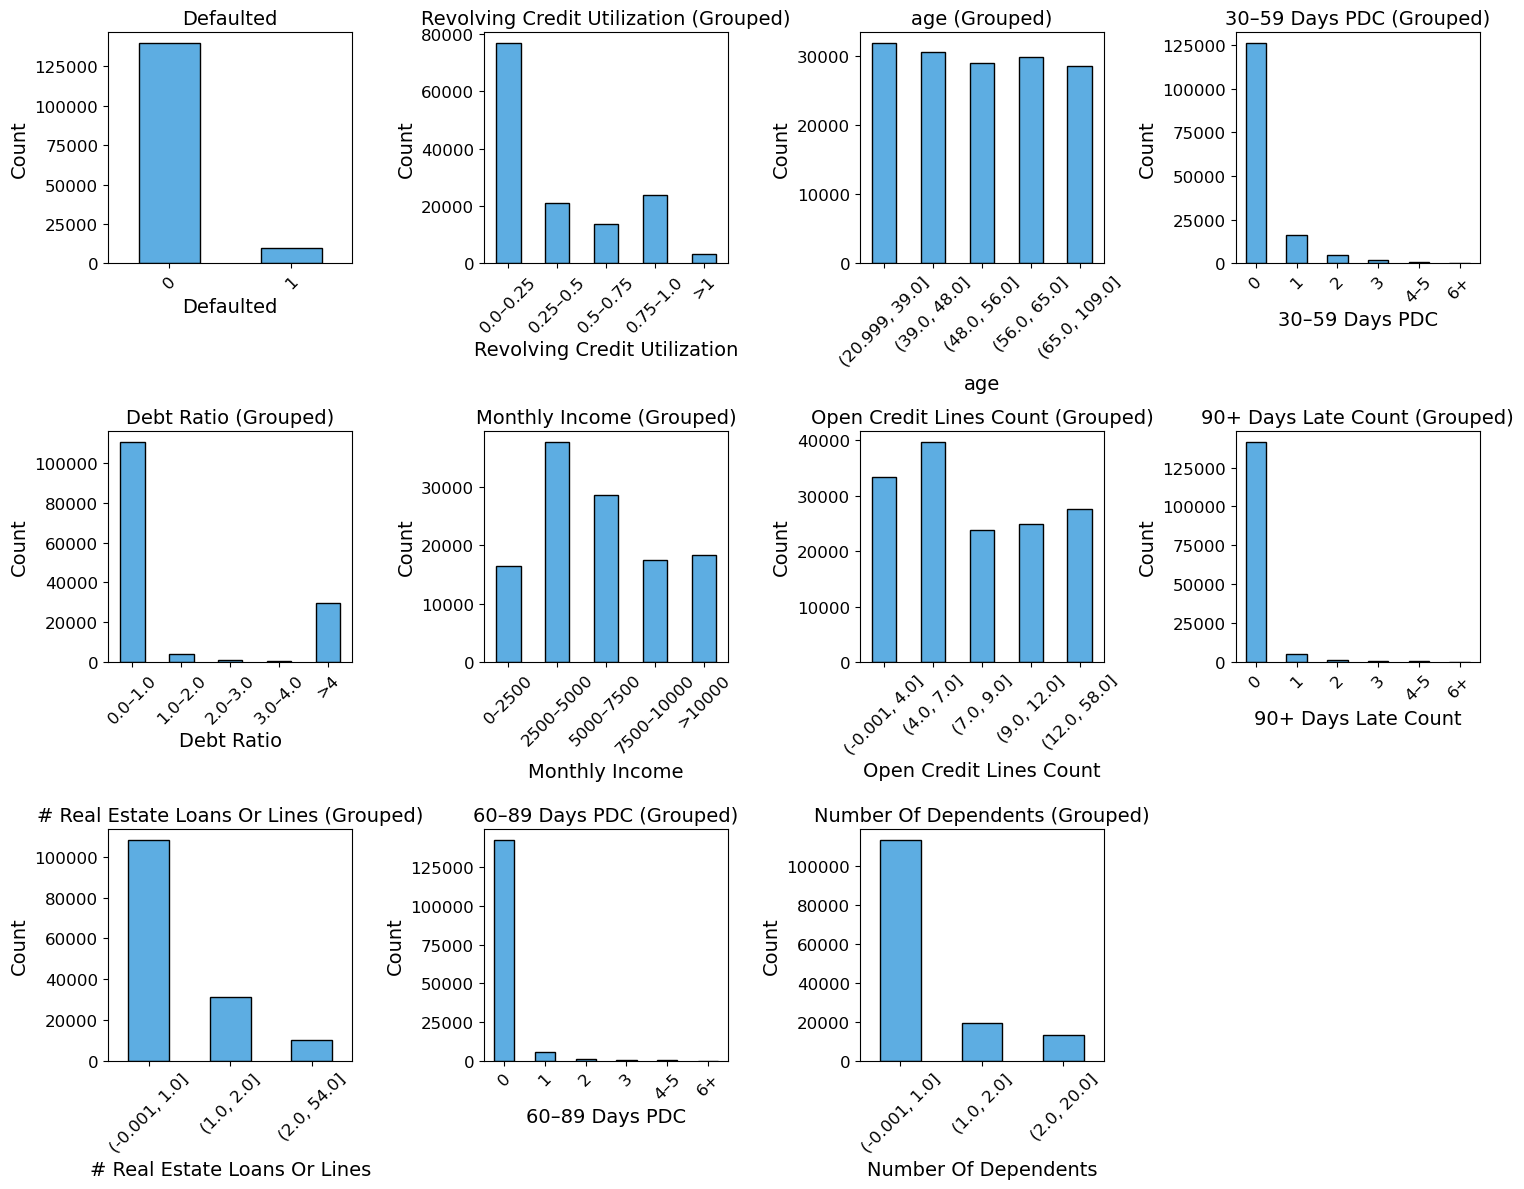

In [9]:
# Font size settings
plt.rcParams.update({
    'figure.figsize': (15, 12),    # overall figure size
    'axes.titlesize': 14,          # subplot titles
    'axes.labelsize': 14,          # x/y axis labels
    'xtick.labelsize': 12,         # x‐tick labels
    'ytick.labelsize': 12,         # y‐tick labels
    'legend.fontsize': 12,         # legend text, if used
})

custom_bin_vars = ["30–59 Days PDC", "60–89 Days PDC", "90+ Days Late Count"]

# Create subplots
fig, axes = plt.subplots(3, 4)
axes = axes.flatten()

for i, col in enumerate(variables_new):
    ax = axes[i]
    data = df[col].dropna()

    # Partial binning for specific PDC variables
    if col in custom_bin_vars:
        bins = [-1, 0, 1, 2, 3, 5, float('inf')]
        labels = ['0', '1', '2', '3', '4–5', '6+']
        binned = pd.cut(data, bins=bins, labels=labels, right=True)
        binned_counts = binned.value_counts().sort_index()

    # Revolving Credit Utilization
    elif col == "Revolving Credit Utilization":
        below_1 = data[data <= 1]
        above_1 = data[data > 1]
        bins = np.linspace(below_1.min(), 1, 5)
        bins = np.append(bins, [above_1.max()])
        labels = [f"{round(bins[j],2)}–{round(bins[j+1],2)}" for j in range(len(bins)-2)] + ['>1']
        cut_points = np.append(bins[:-1], float('inf'))
        binned = pd.cut(data, bins=cut_points, labels=labels, right=True)
        binned_counts = binned.value_counts().sort_index()

    # Debt Ratio
    elif col == "Debt Ratio":
        below_4 = data[data <= 4]
        above_4 = data[data > 4]
        bins = np.linspace(below_4.min(), 4, 5)
        bins = np.append(bins, [above_4.max()])
        labels = [f"{round(bins[j],2)}–{round(bins[j+1],2)}" for j in range(len(bins)-2)] + ['>4']
        cut_points = np.append(bins[:-1], float('inf'))
        binned = pd.cut(data, bins=cut_points, labels=labels, right=True)
        binned_counts = binned.value_counts().sort_index()

    # Monthly Income
    elif col == "Monthly Income":
        below_10k = data[data <= 10000]
        above_10k = data[data > 10000]
        bins = np.linspace(below_10k.min(), 10000, 5)
        bins = np.append(bins, [above_10k.max()])
        labels = [f"{int(bins[j])}–{int(bins[j+1])}" for j in range(len(bins)-2)] + ['>10000']
        cut_points = np.append(bins[:-1], float('inf'))
        binned = pd.cut(data, bins=cut_points, labels=labels, right=True)
        binned_counts = binned.value_counts().sort_index()

    # Binary variables (0/1)
    elif data.nunique() <= 5 and set(data.unique()) <= {0, 1}:
        binned_counts = data.value_counts().sort_index()
        binned_counts.plot.bar(ax=ax, color='#5DADE2', edgecolor='black')
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.tick_params(axis='x', labelrotation=45)
        continue

    # Default quantile‐based binning
    else:
        try:
            binned = pd.qcut(data, q=5, duplicates='drop')
        except ValueError:
            binned = pd.qcut(data, q=min(10, data.nunique()), duplicates='drop')
        binned_counts = binned.value_counts().sort_index()

    # Plot grouped bar
    binned_counts.plot.bar(ax=ax, color='#5DADE2', edgecolor='black')
    ax.set_title(f"{col} (Grouped)")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', labelrotation=45)

# Remove unused subplots
for j in range(len(variables_new), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [10]:
# Count defaults and non defaults
counts = df["Defaulted"].value_counts()
percentages = df["Defaulted"].value_counts(normalize=True) * 100

# Print results with counts and percentages
print("Before dropping missing values rows:")
print(f"Non-defaults (0): {counts.get(0, 0)} ({percentages.get(0, 0):.2f}%)")
print(f"Defaults (1): {counts.get(1, 0)} ({percentages.get(1, 0):.2f}%)")

Before dropping missing values rows:
Non-defaults (0): 139690 (93.40%)
Defaults (1): 9873 (6.60%)


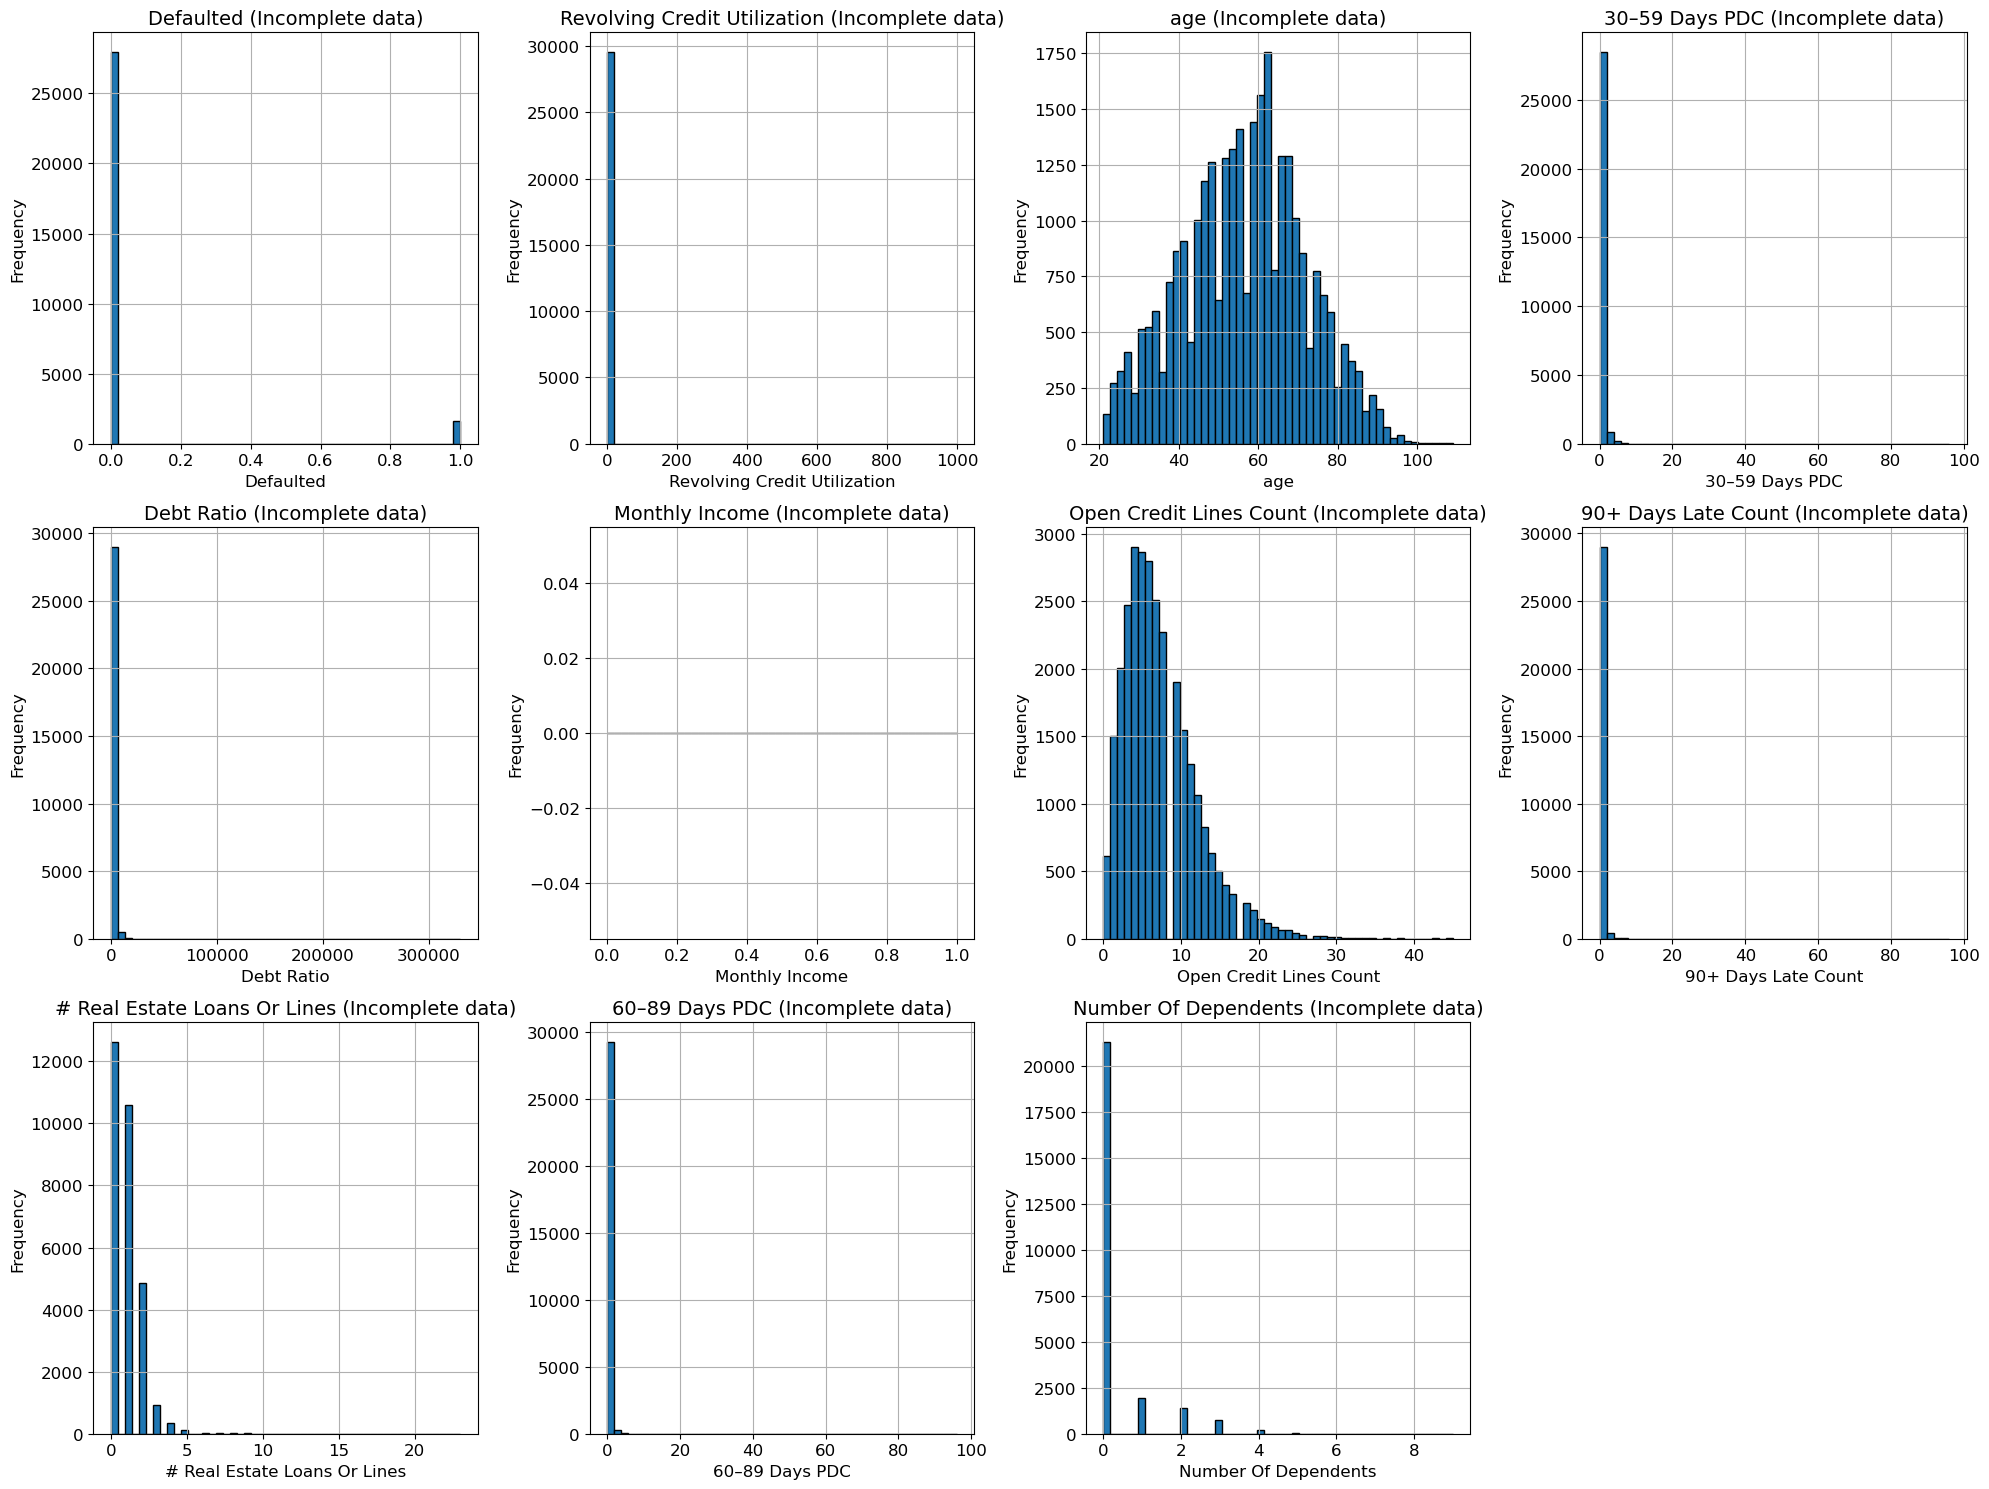

In [11]:
# Keep only rows with at least one missing value
df_missing = df[df.isnull().any(axis=1)]

# Set up a 3x4 subplot grid (one left blank)
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# Plot histograms for each selected variable for rows with missing data
for i, col in enumerate(variables_new):
    ax = axes[i]
    df_missing[col].dropna().hist(ax=ax, bins=50, edgecolor='black')
    ax.set_title(f'{col} (Incomplete data)', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

# Hide the unused subplot (last one in 3x4 grid)
for j in range(len(variables_new), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


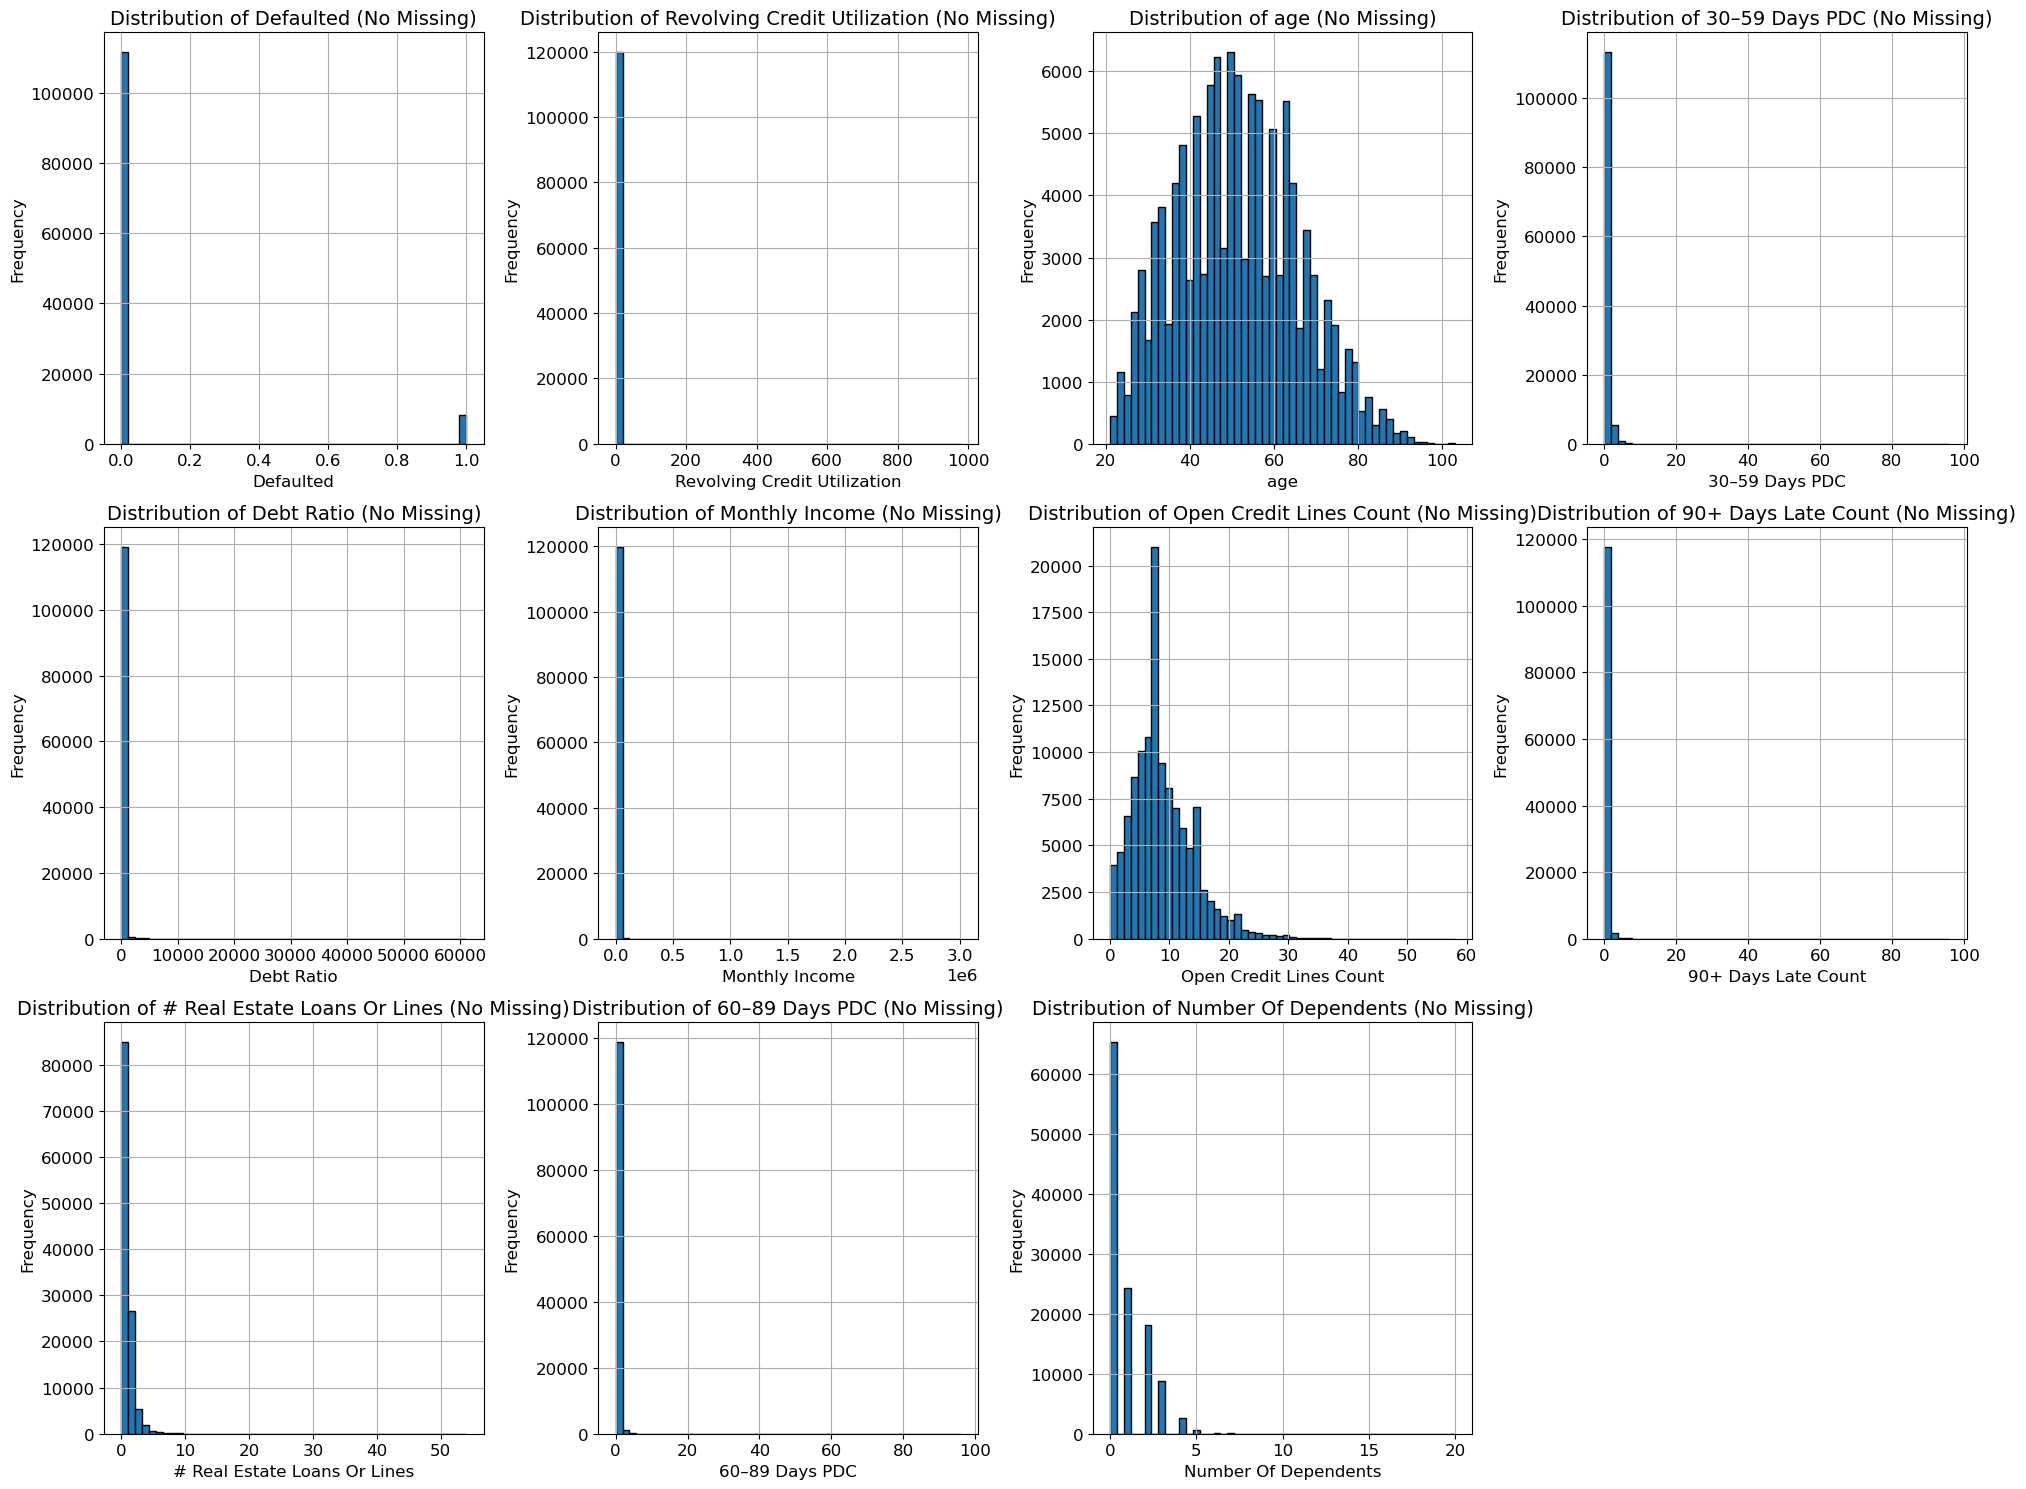

In [12]:
# Rename columns
df_clean_1 = df.dropna()

# Set up 3x4 plot grid
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# Plot each variable's histogram
for i, col in enumerate(variables_new):
    ax = axes[i]
    df_clean_1[col].dropna().hist(ax=ax, bins=50, edgecolor='black')
    ax.set_title(f'Distribution of {col} (No Missing)', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

# Hide unused subplot if necessary
for j in range(len(variables_new), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()

In [13]:
# Count defaults and non defaults
counts = df_clean_1["Defaulted"].value_counts()
percentages = df_clean_1["Defaulted"].value_counts(normalize=True) * 100

# Print results with counts and percentages
print("After dropping missing values rows:")
print(f"Non-defaults (0): {counts.get(0, 0)} ({percentages.get(0, 0):.2f}%)")
print(f"Defaults (1): {counts.get(1, 0)} ({percentages.get(1, 0):.2f}%)")

After dropping missing values rows:
Non-defaults (0): 111730 (93.11%)
Defaults (1): 8268 (6.89%)


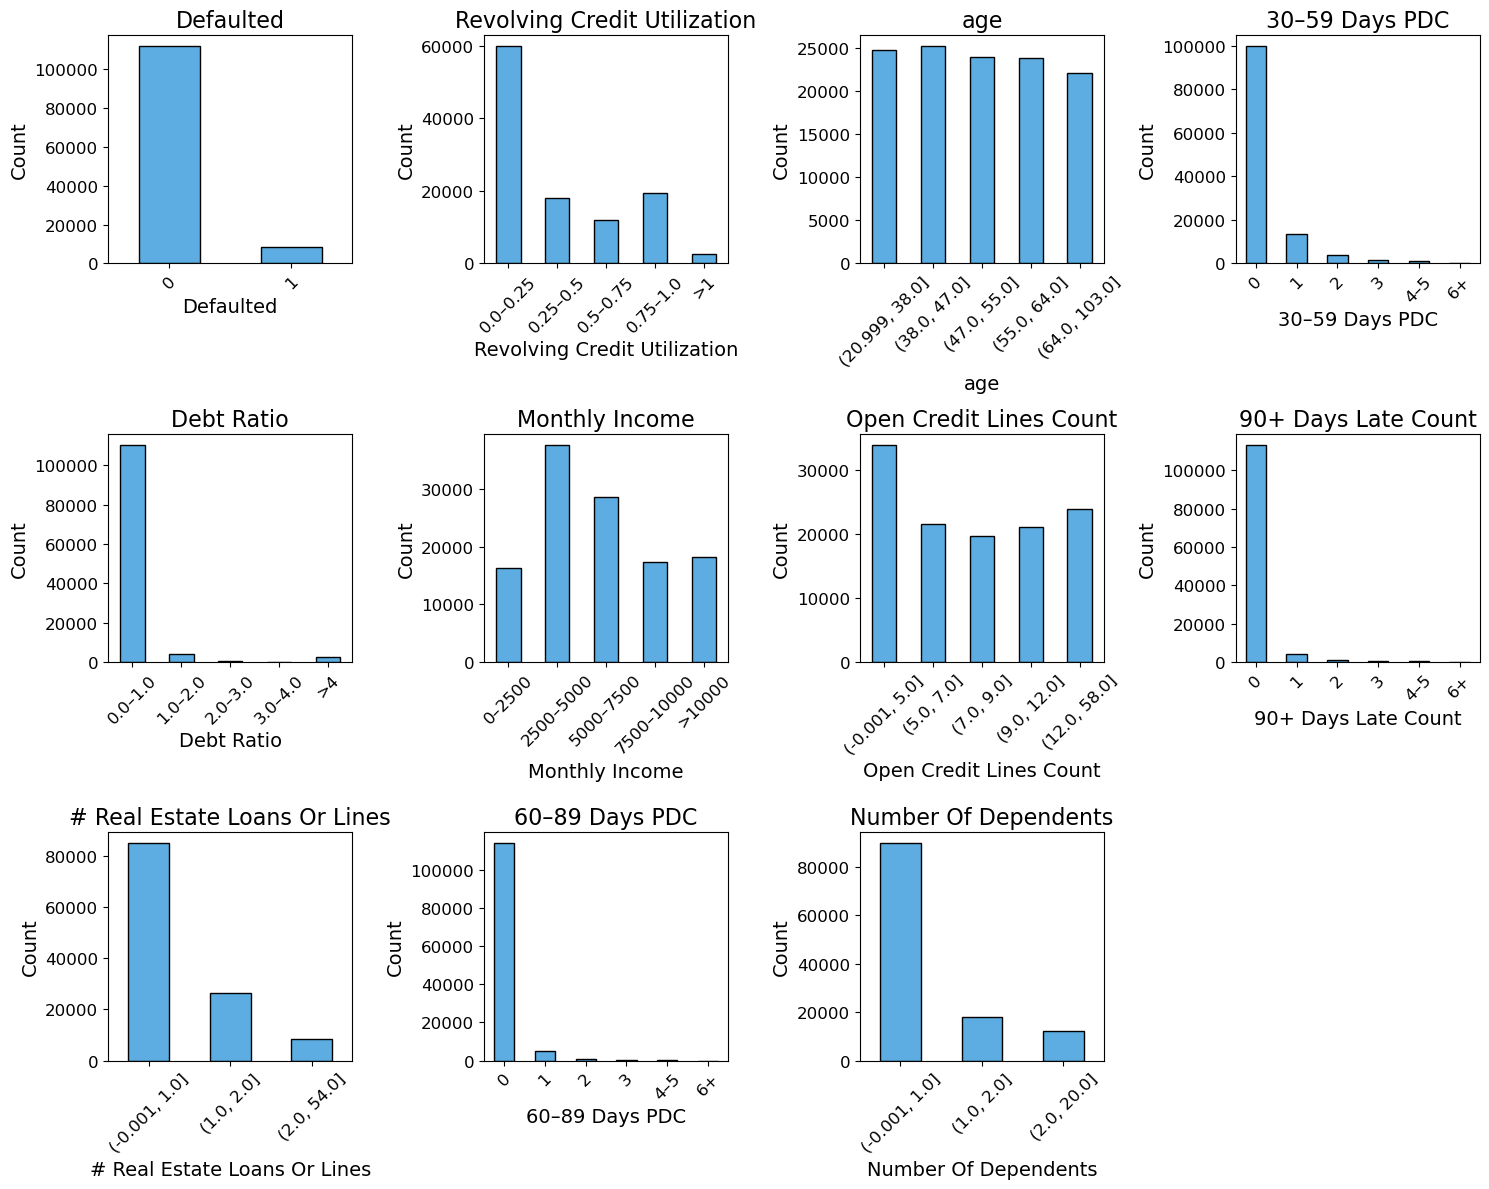

In [14]:
# Global font-size settings
plt.rcParams.update({
    'figure.figsize': (15, 12),    # overall figure size
    'axes.titlesize': 16,          # subplot titles
    'axes.labelsize': 14,          # x/y axis labels
    'xtick.labelsize': 12,         # x-tick labels
    'ytick.labelsize': 12,         # y-tick labels
    'legend.fontsize': 12,         # legend text, if used
})

custom_bin_vars = ["30–59 Days PDC", "60–89 Days PDC", "90+ Days Late Count"]

# Create subplots
fig, axes = plt.subplots(3, 4)
axes = axes.flatten()

for i, col in enumerate(variables_new):
    ax = axes[i]
    data = df_clean_1[col].dropna()

    # Partial binning for specific PDC variables
    if col in custom_bin_vars:
        bins = [-1, 0, 1, 2, 3, 5, float('inf')]
        labels = ['0', '1', '2', '3', '4–5', '6+']
        binned = pd.cut(data, bins=bins, labels=labels, right=True)
        binned_counts = binned.value_counts().sort_index()

    # Revolving Credit Utilization
    elif col == "Revolving Credit Utilization":
        below_1 = data[data <= 1]
        above_1 = data[data > 1]
        bins = np.linspace(below_1.min(), 1, 5)
        bins = np.append(bins, [above_1.max()])
        labels = [f"{round(bins[j],2)}–{round(bins[j+1],2)}" for j in range(len(bins)-2)] + ['>1']
        cut_points = np.append(bins[:-1], float('inf'))
        binned = pd.cut(data, bins=cut_points, labels=labels, right=True)
        binned_counts = binned.value_counts().sort_index()

    # Debt Ratio
    elif col == "Debt Ratio":
        below_4 = data[data <= 4]
        above_4 = data[data > 4]
        bins = np.linspace(below_4.min(), 4, 5)
        bins = np.append(bins, [above_4.max()])
        labels = [f"{round(bins[j],2)}–{round(bins[j+1],2)}" for j in range(len(bins)-2)] + ['>4']
        cut_points = np.append(bins[:-1], float('inf'))
        binned = pd.cut(data, bins=cut_points, labels=labels, right=True)
        binned_counts = binned.value_counts().sort_index()

    # Monthly Income
    elif col == "Monthly Income":
        below_10k = data[data <= 10000]
        above_10k = data[data > 10000]
        bins = np.linspace(below_10k.min(), 10000, 5)
        bins = np.append(bins, [above_10k.max()])
        labels = [f"{int(bins[j])}–{int(bins[j+1])}" for j in range(len(bins)-2)] + ['>10000']
        cut_points = np.append(bins[:-1], float('inf'))
        binned = pd.cut(data, bins=cut_points, labels=labels, right=True)
        binned_counts = binned.value_counts().sort_index()

    # Binary variables (0/1)
    elif data.nunique() <= 5 and set(data.unique()) <= {0, 1}:
        binned_counts = data.value_counts().sort_index()
        binned_counts.plot.bar(ax=ax, color='#5DADE2', edgecolor='black')
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.tick_params(axis='x', labelrotation=45)
        continue

    # Default quantile based binning
    else:
        try:
            binned = pd.qcut(data, q=5, duplicates='drop')
        except ValueError:
            binned = pd.qcut(data, q=min(10, data.nunique()), duplicates='drop')
        binned_counts = binned.value_counts().sort_index()

    # Plot grouped bar
    binned_counts.plot.bar(ax=ax, color='#5DADE2', edgecolor='black')
    ax.set_title(f"{col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', labelrotation=45)

# Remove unused subplots
for j in range(len(variables_new), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [15]:
# List of variables to log-transform
variables_log_transform = [
    "Revolving Credit Utilization",
    "30–59 Days PDC",
    "Debt Ratio",
    "Monthly Income",
    "Open Credit Lines Count",
    "90+ Days Late Count",
    "# Real Estate Loans Or Lines",
    "60–89 Days PDC",
    "Number Of Dependents"
]

# Ensure df_clean_1 is a safe copy
df_clean_1 = df_clean_1.copy()

# Then apply log transform safely
for col in variables_log_transform:
    df_clean_1[f"log_{col}"] = np.log1p(df_clean_1[col])


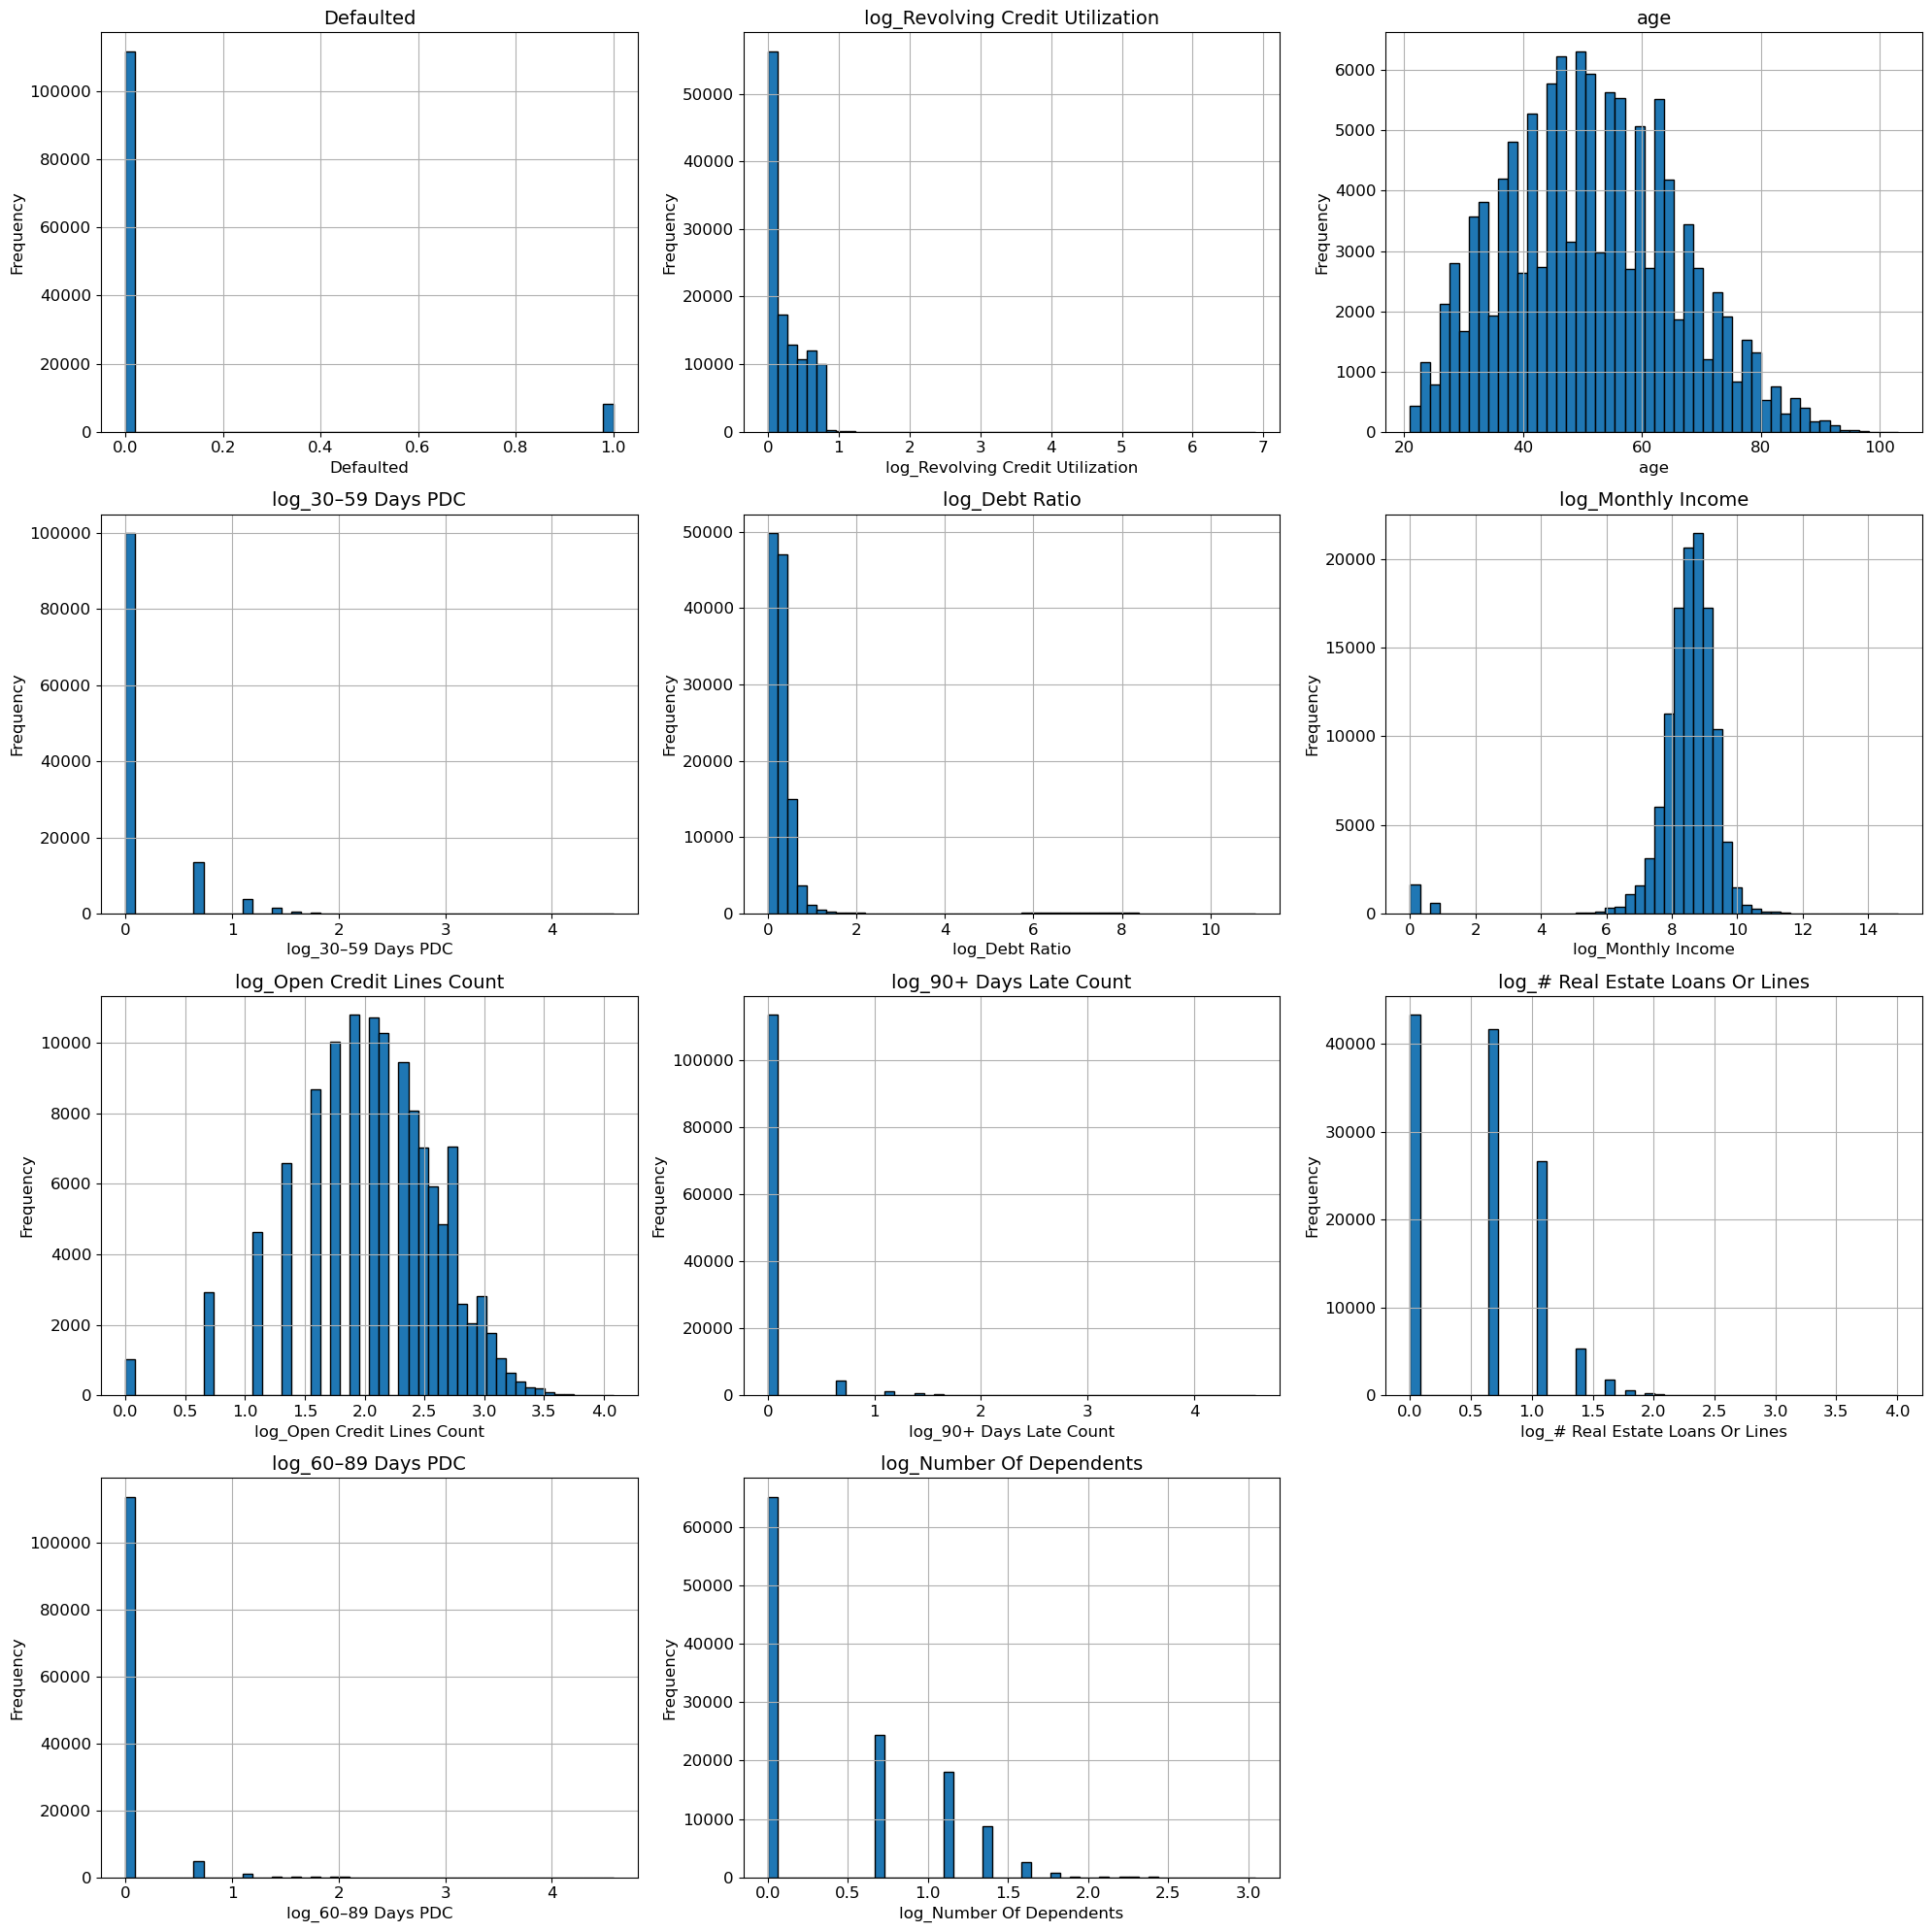

In [16]:
# List of variables to plot
variables_log = [
    "Defaulted",
    "log_Revolving Credit Utilization",
    "age",
    "log_30–59 Days PDC",
    "log_Debt Ratio",
    "log_Monthly Income",
    "log_Open Credit Lines Count",
    "log_90+ Days Late Count",
    "log_# Real Estate Loans Or Lines",
    "log_60–89 Days PDC",
    "log_Number Of Dependents"
]

# Set up subplot grid (4x3 to fit 11 plots with 1 empty)
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(variables_log):
    ax = axes[i]
    df_clean_1[col].dropna().hist(ax=ax, bins=50, edgecolor='black')
    ax.set_title(f'{col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

# Hide any unused subplots
for j in range(len(variables_log), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [17]:
df_clean_2 = df_clean_1[variables_log]

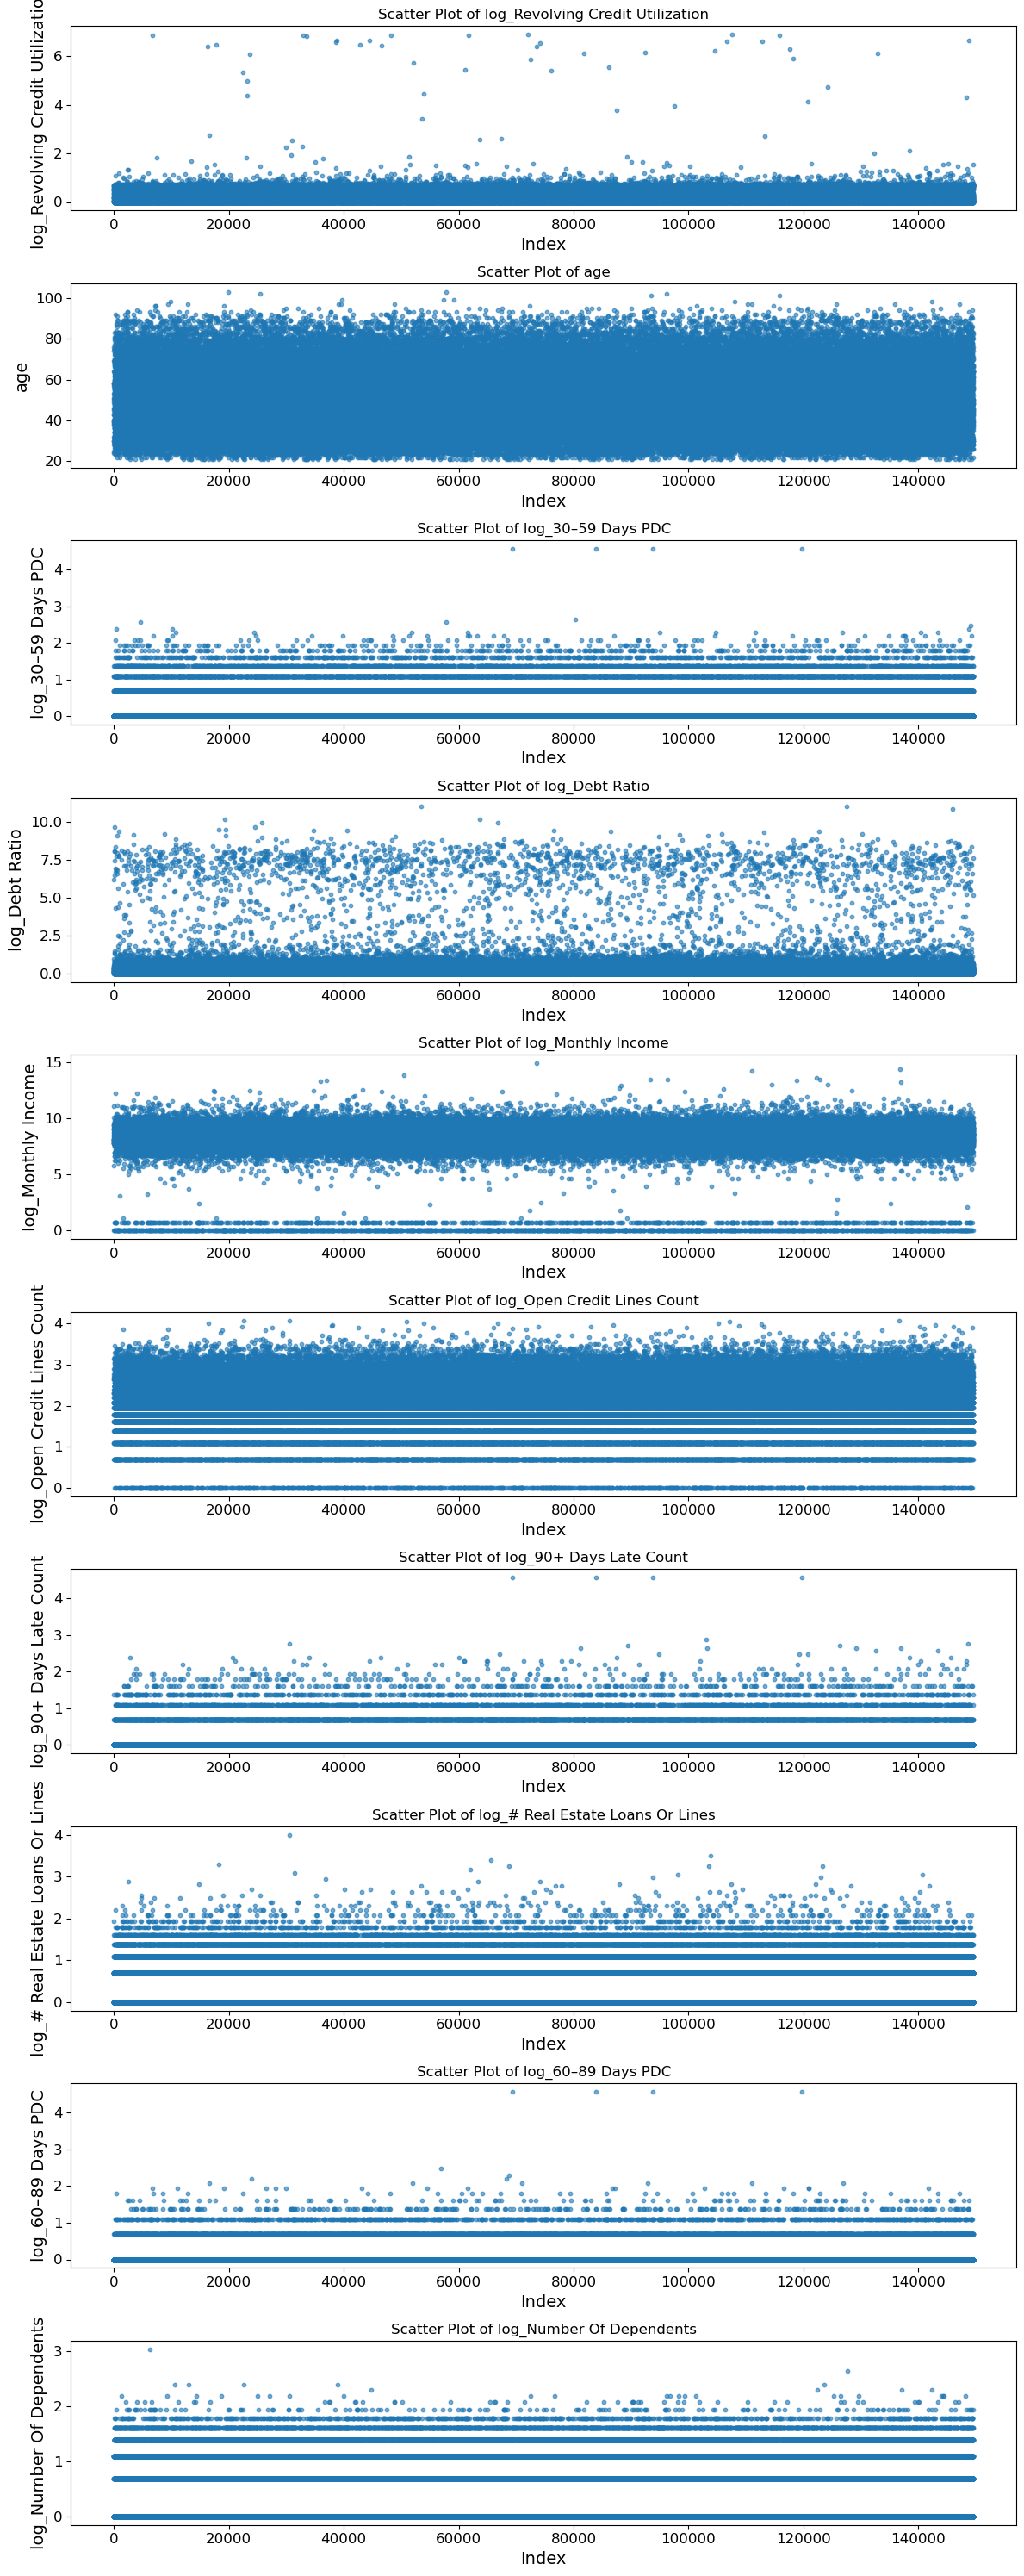

In [18]:
# Create new dataframe with only age, defaulted and log transformed variables, also exclude 'Defaulted' from the variables as this is a binary variable so no outliers can be detected for this variable
df_clean_2 = df_clean_1[variables_log]
vars_to_check = [col for col in df_clean_2.columns if col != "Defaulted"]

# Set up subplots
fig, axes = plt.subplots(len(vars_to_check), 1, figsize=(12, 3 * len(vars_to_check)))

# Plot each variable as a scatter plot so see if any visual outliers appear
for i, col in enumerate(vars_to_check):
    ax = axes[i]
    ax.scatter(df_clean_2.index, df_clean_2[col], alpha=0.6, s=10)
    ax.set_title(f'Scatter Plot of {col}', fontsize=12)
    ax.set_xlabel('Index')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()


From this scatter plot above we still see 4 likely outliers in the variables "30–59 Days PDC", "90+ Days Late Count" and "60–89 Days PDC", these are the final deleted observations of our dataset before moving to the modelling part.

In [19]:
# List of columns to check
cols_with_outliers = [
    "log_30–59 Days PDC",
    "log_90+ Days Late Count",
    "log_60–89 Days PDC"
]

# Apply condition to remove rows with value > 3 in any of these columns, as we can observe from the scatter plots that the 4 outliers uniquely suffice this condition
condition = (df_clean_2[cols_with_outliers] > 3).any(axis=1)
num_removed = condition.sum()

# Filter the DataFrame
df_clean_2 = df_clean_2[~condition].reset_index(drop=True)

# Report
print(f"Removed {num_removed} rows with log delinquency values > 3 as this is what specifically clasifies the 4 described final outliers above for the delinquency events variables.")
print(f"New shape of df_clean_2: {df_clean_2.shape}")


Removed 4 rows with log delinquency values > 3 as this is what specifically clasifies the 4 described final outliers above for the delinquency events variables.
New shape of df_clean_2: (119994, 11)


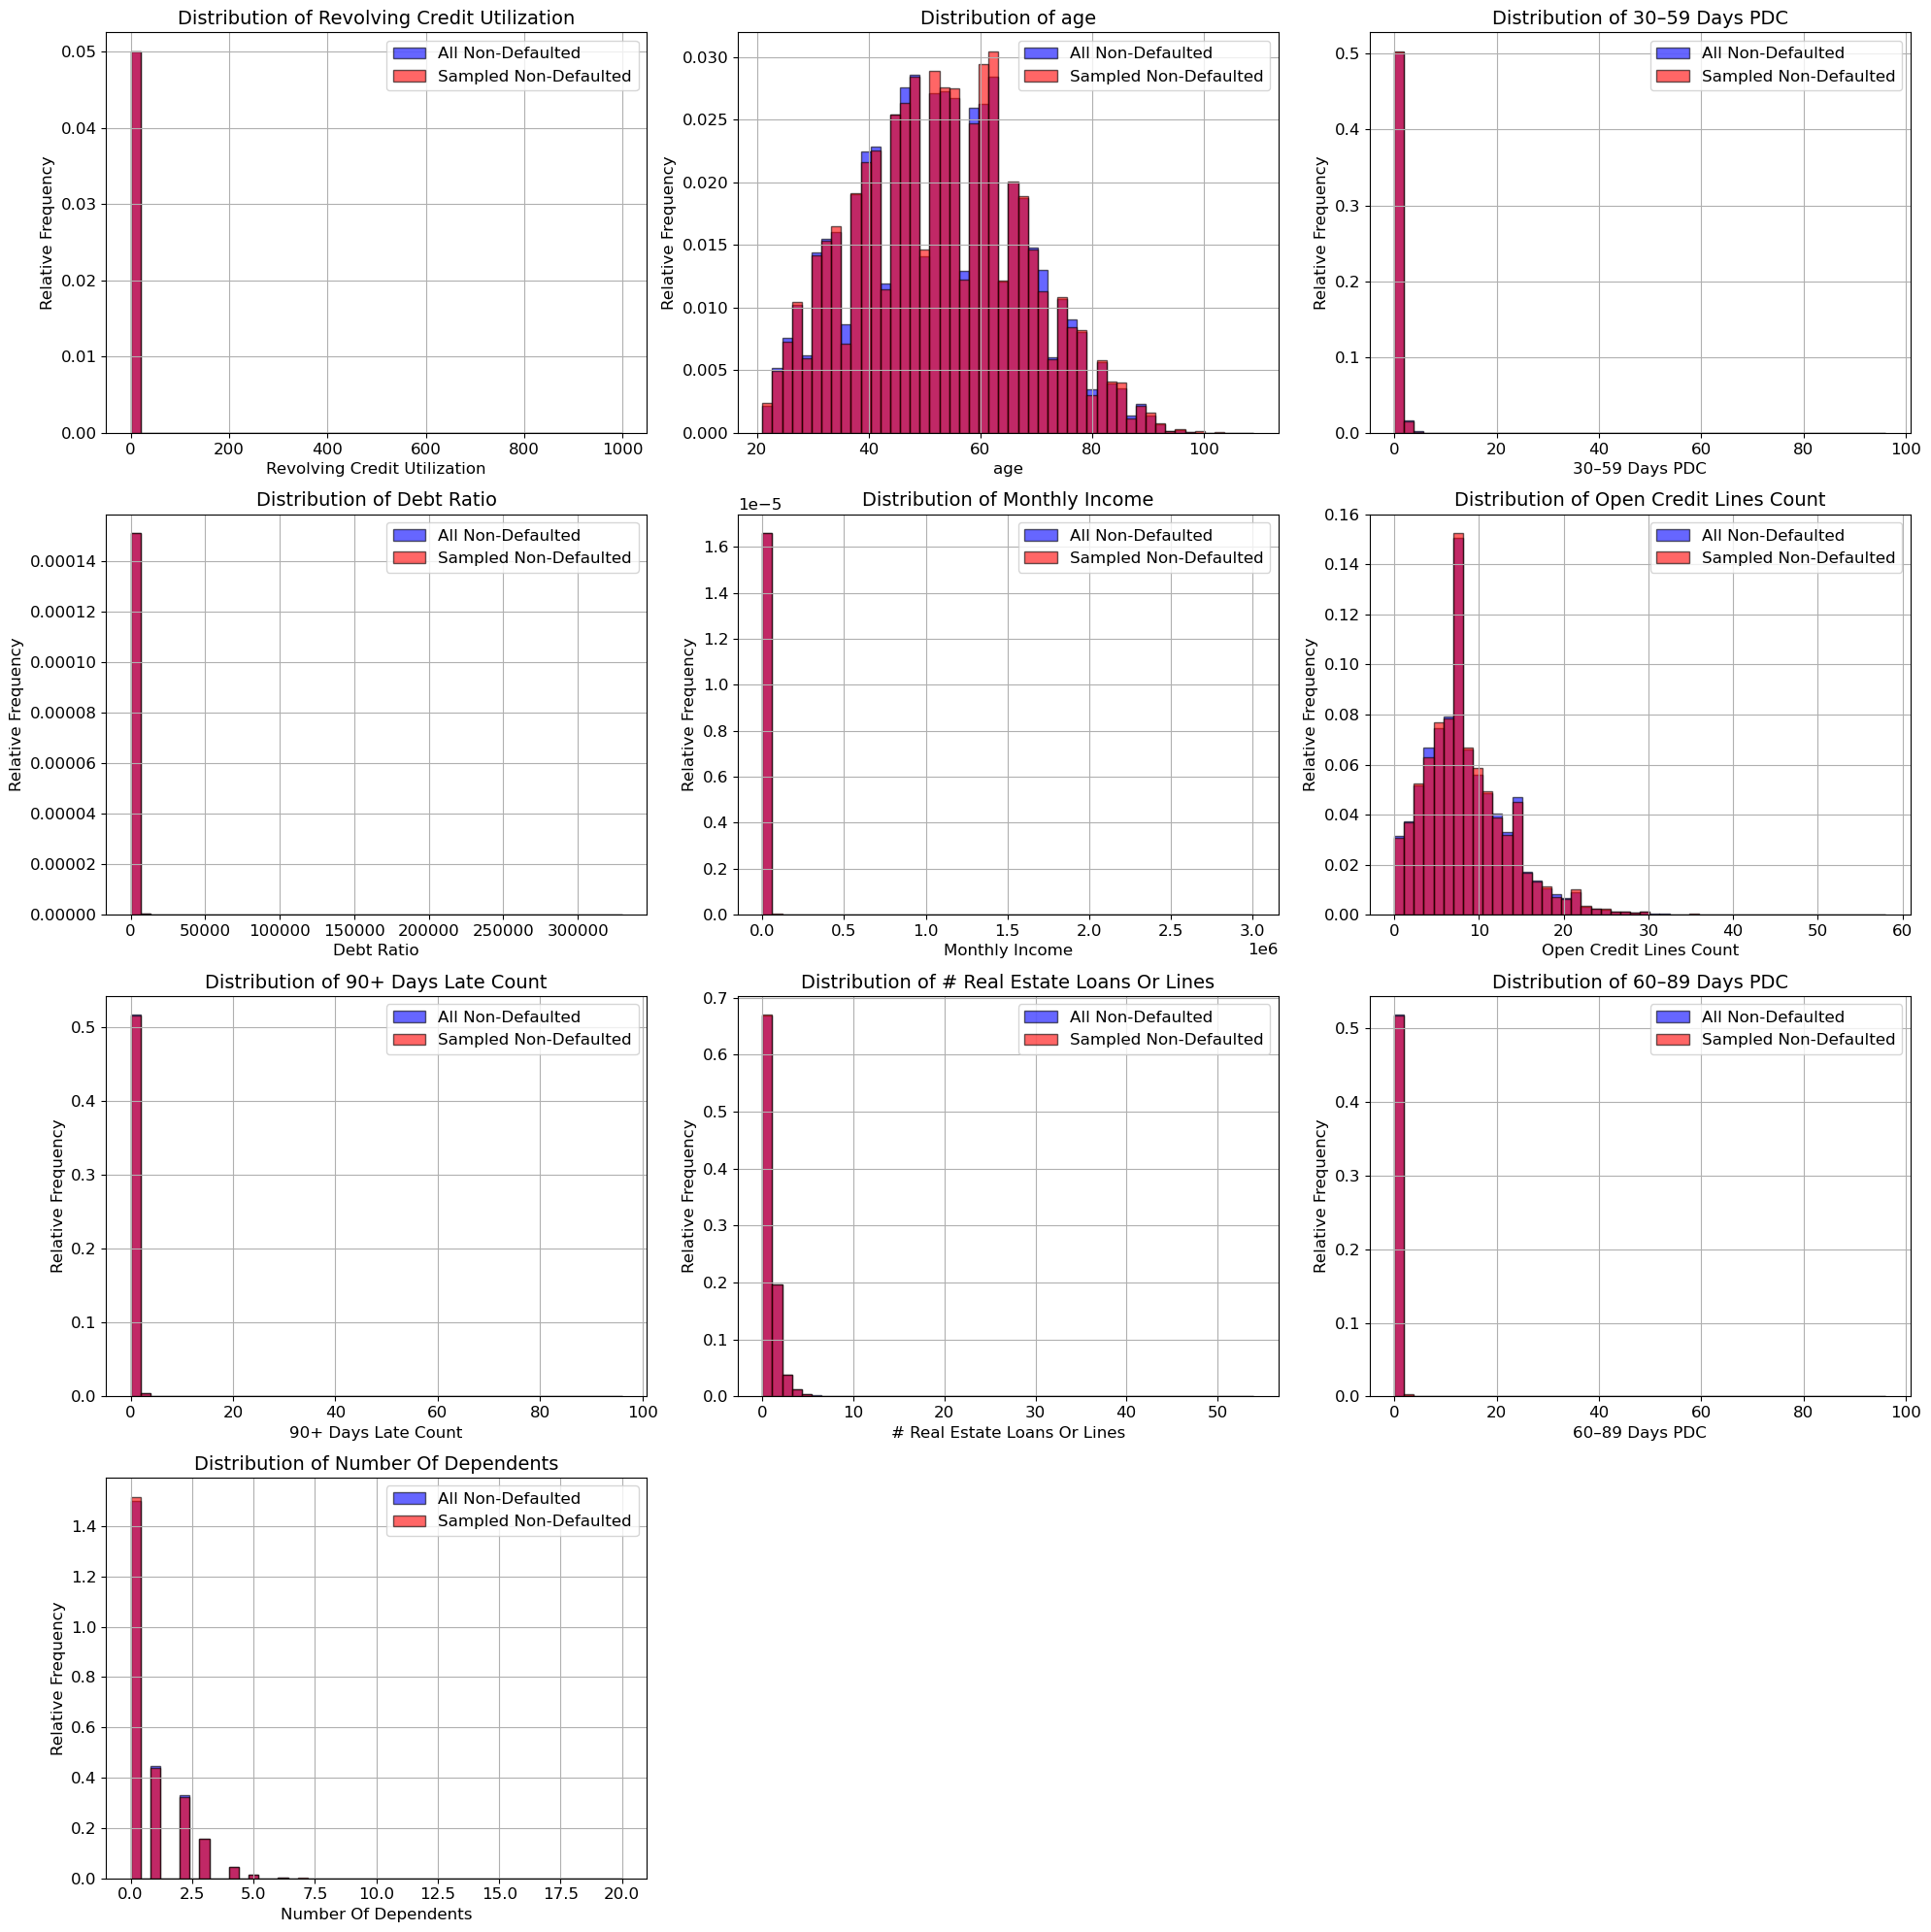

In [20]:
# Separate groups
non_defaulted = df[df["Defaulted"] == 0]
defaulted = df[df["Defaulted"] == 1]

# Define explanatory variables
explanatory_vars = [
    "Revolving Credit Utilization",
    "age",
    "30–59 Days PDC",
    "Debt Ratio",
    "Monthly Income",
    "Open Credit Lines Count",
    "90+ Days Late Count",
    "# Real Estate Loans Or Lines",
    "60–89 Days PDC",
    "Number Of Dependents"
]

# Downsample majority class
non_defaulted_sample = non_defaulted.sample(n=len(defaulted), random_state=42)

# Plot with shared bin edges (equal bar widths) to illustrate that despite the undersampling the distributions of the explanatory 
# variables are almost equal for all non-default obervations and the undersampled group of non-defaulted observations
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(explanatory_vars):
    ax = axes[i]

    # Combine both subsets to get common min/max
    combined = pd.concat([non_defaulted[col], non_defaulted_sample[col]]).dropna()
    min_val, max_val = combined.min(), combined.max()
    bins = np.linspace(min_val, max_val, 51)  # 50 equal width bins

    # Plot full non defaulted (blue)
    non_defaulted[col].dropna().hist(
        ax=ax, bins=bins, color='blue', edgecolor='black', alpha=0.6, density=True, label='All Non-Defaulted'
    )

    # Plot sampled non defaulted (red)
    non_defaulted_sample[col].dropna().hist(
        ax=ax, bins=bins, color='red', edgecolor='black', alpha=0.6, density=True, label='Sampled Non-Defaulted'
    )

    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Relative Frequency", fontsize=12)
    ax.legend()

# Hide unused subplots
for j in range(len(explanatory_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() 
plt.show()


In [21]:
# Separate features and target
X = df_clean_2.drop(columns=["Defaulted"])
y = df_clean_2["Defaulted"]

# Create df_undersamp (downsampled/undersampled)
# Split the dataset
defaulted = df_clean_2[df_clean_2["Defaulted"] == 1]
non_defaulted = df_clean_2[df_clean_2["Defaulted"] == 0]

# Randomly sample non defaults to match the number of defaults
non_defaulted_sample = non_defaulted.sample(n=len(defaulted), random_state=42)

# Combine and shuffle
df_undersamp = pd.concat([defaulted, non_defaulted_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Create df_SMOTE (oversampled with SMOTE)
# We can apply SMOTE as all variables in the dataset are numeric
X_numeric = X.select_dtypes(include='number')

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_numeric, y)

# Recombine
df_SMOTE = pd.concat([X_resampled, y_resampled], axis=1)

# Summary
print(f"df_undersamp shape: {df_undersamp.shape} (balanced by downsampling)")
print(f"df_SMOTE shape:     {df_SMOTE.shape} (balanced by oversampling)")
print("\nClass distribution in df_undersamp:")
print(df_undersamp['Defaulted'].value_counts())

print("\nClass distribution in df_SMOTE:")
print(df_SMOTE['Defaulted'].value_counts())


df_undersamp shape: (16530, 11) (balanced by downsampling)
df_SMOTE shape:     (223458, 11) (balanced by oversampling)

Class distribution in df_undersamp:
Defaulted
0    8265
1    8265
Name: count, dtype: int64

Class distribution in df_SMOTE:
Defaulted
1    111729
0    111729
Name: count, dtype: int64


In [ ]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Analysis models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

def evaluate_models_with_reports(df, label):
    X = df.drop(columns=["Defaulted"])
    y = df["Defaulted"]
    results = []

    for model_name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clone(model))
        ])
        
        y_true_all, y_pred_all = [], []
        
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            
            y_true_all.extend(y_test)
            y_pred_all.extend(y_pred)

        # Classification report
        report = classification_report(y_true_all, y_pred_all, output_dict=True, zero_division=0)
        
        # Confusion matrix
        cm = confusion_matrix(y_true_all, y_pred_all)
        print(f"\nConfusion Matrix for {model_name} ({label}):")
        print(cm)
        print("Labels: [0 = Non-Default, 1 = Default]")

        results.append({
            "Dataset": label,
            "Model": model_name,
            "Accuracy": report["accuracy"],
            "Precision (Default)": report["1"]["precision"],
            "Recall (Default)": report["1"]["recall"],
            "F1 (Default)": report["1"]["f1-score"],
            "Precision (Non-Default)": report["0"]["precision"],
            "Recall (Non-Default)": report["0"]["recall"],
            "F1 (Non-Default)": report["0"]["f1-score"],
        })

    return pd.DataFrame(results).round(4)

# Evaluate both datasets
results_undersamp = evaluate_models_with_reports(df_undersamp, "Downsampling")
results_smote = evaluate_models_with_reports(df_SMOTE, "SMOTE")

# Combine and print
summary_table = pd.concat([results_undersamp, results_smote], ignore_index=True)
print("\n=== Summary Table ===")
print(summary_table.to_string(index=False))



Confusion Matrix for Logistic Regression (Downsampling):
[[6768 1497]
 [2435 5830]]
Labels: [0 = Non-Default, 1 = Default]

Confusion Matrix for Decision Tree (Downsampling):
[[5599 2666]
 [2593 5672]]
Labels: [0 = Non-Default, 1 = Default]

Confusion Matrix for Random Forest (Downsampling):
[[6494 1771]
 [2053 6212]]
Labels: [0 = Non-Default, 1 = Default]

Confusion Matrix for Logistic Regression (SMOTE):
[[87789 23940]
 [29931 81798]]
Labels: [0 = Non-Default, 1 = Default]

Confusion Matrix for Decision Tree (SMOTE):
[[101420  10309]
 [  8577 103152]]
Labels: [0 = Non-Default, 1 = Default]


In [ ]:
def plot_roc_curves(roc_data, dataset_label):
    plt.figure(figsize=(8, 6))
    
    for model_name, (fpr, tpr, auc_score) in roc_data.items():
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({dataset_label})")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    
    filename = f"roc_curve_{dataset_label.lower().replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300) 
    print(f"ROC curve saved as: {filename}")

    plt.show()
    plt.show()

In [ ]:
def evaluate_models_with_reports(df, label):
    X = df.drop(columns=["Defaulted"])
    y = df["Defaulted"]
    results = []
    roc_data = {}  

    for model_name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clone(model))
        ])
        
        y_true_all, y_pred_all, y_prob_all = [], [], []
        
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            y_prob = pipeline.predict_proba(X_test)[:, 1]

            y_true_all.extend(y_test)
            y_pred_all.extend(y_pred)
            y_prob_all.extend(y_prob)

        report = classification_report(y_true_all, y_pred_all, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_true_all, y_pred_all)
        auc_score = roc_auc_score(y_true_all, y_prob_all)

        fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
        roc_data[model_name] = (fpr, tpr, auc_score)

        print(f"\nConfusion Matrix for {model_name} ({label}):")
        print(cm)
        print("Labels: [0 = Non-Default, 1 = Default]")

        results.append({
            "Dataset": label,
            "Model": model_name,
            "Accuracy": report["accuracy"],
            "ROC AUC": auc_score,
            "Precision (Default)": report["1"]["precision"],
            "Recall (Default)": report["1"]["recall"],
            "F1 (Default)": report["1"]["f1-score"],
            "Precision (Non-Default)": report["0"]["precision"],
            "Recall (Non-Default)": report["0"]["recall"],
            "F1 (Non-Default)": report["0"]["f1-score"],
        })

    plot_roc_curves(roc_data, label)
    
    return pd.DataFrame(results).round(4)

In [ ]:
results_undersamp = evaluate_models_with_reports(df_undersamp, "Downsampling")
results_smote = evaluate_models_with_reports(df_SMOTE, "SMOTE")
summary_table = pd.concat([results_undersamp, results_smote], ignore_index=True)
print(summary_table.to_string(index=False)) 

In [ ]:
results_undersamp

In [ ]:
results_smote

In [ ]:
summary_table

In [ ]:
df_undersamp.describe() 